In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split



import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape,Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D,UpSampling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


df_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
df_prompt = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
test1 = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [31]:
df_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [32]:
df_prompt.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [33]:
df_train_essays_ext = pd.read_csv('/kaggle/input/new-data/train_v2_drcat_02.csv')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [34]:
df_train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

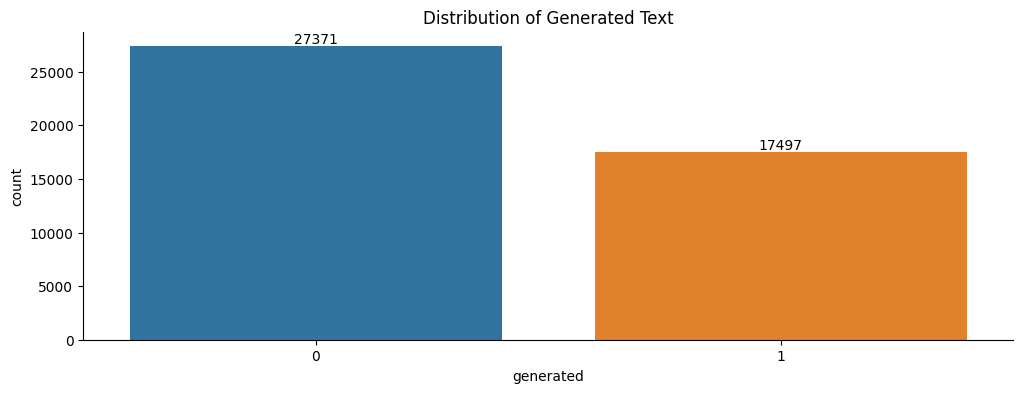

In [35]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [36]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_essay[["text", "generated"]]])
import re # regular expression library
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def normalize(text):
    # Replace with whitespace to separate '\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces from '  For' to ' For'
    text = re.sub(r"\s+", r" ", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #lower case the all capital alphabets
    text=text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

df_train_essays_final['text'] = df_train_essays_final['text'].apply(lambda x: normalize(x))
test1['text'] = test1['text'].apply(lambda x: normalize(x))

df_train_essays_final.info()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train_essays_final['text'])# gives a index on each word
b1=len(tokenizer.word_index)# total no of words

In [39]:
a=tokenizer.texts_to_sequences(df_train_essays_final['text'])
maxi=max(len(x) for x in a)

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
a1=pad_sequences(a,maxlen=maxi,padding='post')

df_train_essays_final['text']=a1.tolist()
import numpy as np
X = np.vstack(df_train_essays_final['text'].to_numpy())
y=np.vstack(df_train_essays_final['generated'].to_numpy())

In [41]:
df_train_essays_final.head()

,text,generated
0,"[59, 1103, 328, 348, 91, 79, 91, 79, 343, 53, ...",0
1,"[327, 1089, 217, 41, 29, 2520, 1092, 1018, 438...",0
2,"[35, 29, 2481, 1092, 348, 384, 18756, 420, 36,...",0
3,"[59, 35, 217, 41, 29, 59, 1018, 438, 217, 166,...",0
4,"[98, 79, 4096, 35, 409, 222, 1366, 2, 31, 437,...",0


In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 300)

In [61]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=512)

In [62]:
#encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
#encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [63]:
#train_labels = torch.tensor(y_train.values)
#val_labels = torch.tensor(y_val.values)

In [64]:
#train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
#val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [65]:
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [66]:
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

In [67]:
#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
#epochs = 20

#for epoch in range(epochs):
    #model.train()
    #total_loss = 0

    #for batch in train_loader:
        #input_ids, attention_mask, labels = batch
        #input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        #optimizer.zero_grad()

        #outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #loss = outputs.loss
        #total_loss += loss.item()

        #loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
       # optimizer.step()

    #avg_train_loss = total_loss / len(train_loader)
   # print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")

In [68]:
class Positional_Embeddings(layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = output_dim)
        self.token_embeddings = layers.Embedding(
        input_dim = vocab_size, output_dim = output_dim)    
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start = 0, limit = length, delta = 1)
        embedded_positions = self.position_embeddings(positions)
        inputs = self.token_embeddings(inputs)
        return inputs + embedded_positions
    
    def compute_masks(self, inputs, masks = None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis = -1)
        return mask

In [69]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.3
        )
        self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation = tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        
        
    def call(self, inputs, mask = None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        attention_output = self.attention(inputs, inputs, attention_mask = mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)

In [70]:
embed_dim = 10
heads = 10
dense_dim = 32
maxlen = maxi
vocab_size = b1+1

inputs = layers.Input(shape=(maxlen,))
embedding_layer = Positional_Embeddings(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, dense_dim, heads)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.30)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
history = model.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=32,
                    )

Epoch 1/5
925/925 [==============================] - 101s 109ms/step - loss: 0.0179 - accuracy: 0.9955 - val_loss: 0.0200 - val_accuracy: 0.9941
Epoch 2/5
925/925 [==============================] - 98s 106ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0189 - val_accuracy: 0.9951
Epoch 3/5
925/925 [==============================] - 97s 105ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0171 - val_accuracy: 0.9950
Epoch 4/5
925/925 [==============================] - 97s 105ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0160 - val_accuracy: 0.9955
Epoch 5/5
925/925 [==============================] - 97s 105ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0395 - val_accuracy: 0.9916


In [73]:
test_sequences = tokenizer.texts_to_sequences(test1['text'])
X_test_padded = pad_sequences(test_sequences, maxlen=maxi)  # Adjust maxlen based on your model

# Make predictions using the trained model
predictions = model.predict(X_test_padded)

# Assuming 'id' is the column containing unique identifiers in the test set
# Create a DataFrame to store the results
results_df = pd.DataFrame({'id': test1['id'], 'generated': predictions.flatten()})

# Save the results to a CSV file
results_df.to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 394ms/step


In [74]:
final=pd.read_csv('submission.csv')
final.head()

,id,generated
0,0000aaaa,0.000593
1,1111bbbb,0.000795
2,2222cccc,0.000795
